In [6]:
#import necessary modules
#Python >= 3.5
import sys
assert sys.version_info >= (3, 5)

#Scikit-Learn >= 0.20
import sklearn as sk
assert sk.__version__ >= "0.20"

#numpy for calculations
import numpy as np
import os

#matplotlib for figures
import matplotlib as mpl
import matplotlib.pyplot as plt
#a magic function that allows inline plotting so figures are rendered in this notebook
%matplotlib inline

#pandas for ...
import pandas as pd
from pandas.plotting import scatter_matrix

#add other needed modules here
#Tensorflow?

## Setup and Feature Statistics

In [7]:
# load data from the cv file using pandas
scores = pd.read_csv("Complete MCAT Data.csv", header = 1)

# rename some columns for consistency
scores.rename(columns = {'Days Before Exam':'Days Before Exam.1', 'Days Before Exam.1':'Days Before Exam.2', 'Days Before Exam.2':'Days Before Exam.3', 'Days Before Exam.3':'Days Before Exam.4'}, inplace = True)

# preview first five lines
scores.head()

,Timestamp,Exam Date,Real Score,C/P Score,CARS Score,B/B Score,P/S Score,Days Before Exam.1,Total Score,C/P Score.1,...,C/P Score.3,CARS Score.3,B/B Score.3,P/S Score.3,Days Before Exam.4,Total Score.3,C/P Score.4,CARS Score.4,B/B Score.4,P/S Score.4
0,2/19/2020 2:17:07,1/18/2020,513.0,128.0,128.0,129.0,128.0,NaN,NaN,NaN,...,128.0,128.0,128.0,126.0,16,506,127,127,125,127
1,2/19/2020 2:32:30,1/17/2020,495.0,122.0,127.0,122.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2/19/2020 2:32:57,1/18/2020,522.0,130.0,129.0,131.0,132.0,5.0,519.0,129.0,...,NaN,NaN,NaN,NaN,512,NaN,NaN,NaN,NaN,NaN
3,2/19/2020 2:37:04,1/17/2020,515.0,128.0,129.0,128.0,130.0,7.0,515.0,129.0,...,127.0,127.0,129.0,127.0,28,506,127,125,127,127
4,2/19/2020 2:37:05,1/17/2020,522.0,131.0,131.0,130.0,130.0,8.0,519.0,131.0,...,130.0,129.0,130.0,131.0,15,519,129,130,129,131


In [8]:
# drop irrelevant columns
scores.drop(columns=['Timestamp', 'Exam Date', 'C/P Score', 'CARS Score', 'B/B Score', 'P/S Score', 'Total Score', 'Total Score.1', 'Total Score.2', 'Total Score.3'], inplace = True)

# sanity check: take a look at the data
print('Scores data shape:', scores.shape)

# look at distribution of scores
scores['Real Score'].value_counts()

# gives count, mean, standard deviation, min, max, and percentiles (including median)
scores.describe(percentiles = [0.25, 0.5, 0.75], include = 'all')

Scores data shape: (4996, 21)


,Real Score,Days Before Exam.1,C/P Score.1,CARS Score.1,B/B Score.1,P/S Score.1,Days Before Exam.2,C/P Score.2,CARS Score.2,B/B Score.2,...,Days Before Exam.3,C/P Score.3,CARS Score.3,B/B Score.3,P/S Score.3,Days Before Exam.4,C/P Score.4,CARS Score.4,B/B Score.4,P/S Score.4
count,4948.000000,1733.000000,1502.000000,1498.000000,1496.000000,1496.000000,2567.000000,2330.000000,2329.000000,2327.000000,...,3303,3044.000000,3043.000000,3042.000000,3042.000000,3340,3544,3543,3541,3544
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,166,NaN,NaN,NaN,NaN,242,17,17,18,18
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21,NaN,NaN,NaN,NaN,28,130,128,130,129
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,333,NaN,NaN,NaN,NaN,269,676,799,796,812
mean,515.914511,8.417773,129.312250,128.403872,129.037433,129.328877,21.421504,129.054506,128.280807,129.329179,...,NaN,128.729632,128.400920,128.880342,127.856673,NaN,NaN,NaN,NaN,NaN
std,23.805011,16.390119,1.996091,2.083215,1.835347,1.885376,365.928234,1.919827,2.156899,1.804962,...,NaN,1.988670,2.358199,1.905568,1.745526,NaN,NaN,NaN,NaN,NaN
min,417.000000,0.000000,120.000000,120.000000,122.000000,122.000000,-8764.000000,121.000000,122.000000,120.000000,...,NaN,118.000000,118.000000,118.000000,118.000000,NaN,NaN,NaN,NaN,NaN
25%,512.000000,4.000000,128.000000,127.000000,128.000000,128.000000,6.000000,128.000000,127.000000,128.000000,...,NaN,127.000000,127.000000,128.000000,127.000000,NaN,NaN,NaN,NaN,NaN
50%,517.000000,6.000000,130.000000,129.000000,129.000000,130.000000,9.000000,129.000000,128.000000,130.000000,...,NaN,129.000000,129.000000,129.000000,128.000000,NaN,NaN,NaN,NaN,NaN
75%,520.000000,7.000000,131.000000,130.000000,130.000000,131.000000,14.000000,130.000000,130.000000,131.000000,...,NaN,130.000000,130.000000,130.000000,129.000000,NaN,NaN,NaN,NaN,NaN


In [9]:
# plot some data statistics for the report
# for report: (state the number of datapoints, briefly describe the dataset)

## Visualize and Handle Missing Data

In [10]:
import missingno as msno

# look at how many values are missing in each dataframe column
missing_values_table(scores)

# visualize missing data with Missingno
msno.bar(scores)
msno.matrix(scores)

# see if there is a reason for missing data
msno.heatmap(scores)
msno.dendrogram(scores)

NameError: name 'missing_values_table' is not defined

In [11]:
# for linear regression, drop all rows with missing values
scores.dropna(axis = 0, inplace = True)

# convert all remaining data to integers
for col in scores.columns:
        scores[col] = scores[col].astype(int)

In [12]:
# print number of columns, column labels, column data types, memory usage, range index, and non-null number of cells in each column
scores.info()

# preview data
scores.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 3 to 4297
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Real Score          1240 non-null   int64
 1   Days Before Exam.1  1240 non-null   int64
 2   C/P Score.1         1240 non-null   int64
 3   CARS Score.1        1240 non-null   int64
 4   B/B Score.1         1240 non-null   int64
 5   P/S Score.1         1240 non-null   int64
 6   Days Before Exam.2  1240 non-null   int64
 7   C/P Score.2         1240 non-null   int64
 8   CARS Score.2        1240 non-null   int64
 9   B/B Score.2         1240 non-null   int64
 10  P/S Score.2         1240 non-null   int64
 11  Days Before Exam.3  1240 non-null   int64
 12  C/P Score.3         1240 non-null   int64
 13  CARS Score.3        1240 non-null   int64
 14  B/B Score.3         1240 non-null   int64
 15  P/S Score.3         1240 non-null   int64
 16  Days Before Exam.4  1240 non-null   int64


,Real Score,Days Before Exam.1,C/P Score.1,CARS Score.1,B/B Score.1,P/S Score.1,Days Before Exam.2,C/P Score.2,CARS Score.2,B/B Score.2,...,Days Before Exam.3,C/P Score.3,CARS Score.3,B/B Score.3,P/S Score.3,Days Before Exam.4,C/P Score.4,CARS Score.4,B/B Score.4,P/S Score.4
3,515,7,129,128,128,130,14,127,126,128,...,21,127,127,129,127,28,127,125,127,127
4,522,8,131,129,128,131,11,131,128,128,...,4,130,129,130,131,15,129,130,129,131
5,524,6,131,130,132,131,10,131,127,131,...,24,132,130,130,130,90,130,128,130,131
7,518,7,129,130,127,126,14,128,129,127,...,23,125,130,127,124,91,125,130,125,124
8,507,7,128,128,128,128,14,130,130,130,...,21,128,129,128,128,28,129,132,130,130


## Clean Data and Add New Features

In [13]:
# drop rows with # negative values
#                # days before exam > 180
#                # exact duplicate values to another row
#                # impossible scores (>528 total or >132 on any subsection)
remove_indices = []
remove_indices.extend(scores[scores['Real Score']>528].index.values)
remove_indices.extend(scores[scores['Real Score']<472].index.values)
for i in range(1, 5):
    remove_indices.extend(scores[scores['Days Before Exam.'+str(i)]>200].index.values)
    remove_indices.extend(scores[scores['C/P Score.'+str(i)]>132].index.values)
    remove_indices.extend(scores[scores['CARS Score.'+str(i)]>132].index.values)
    remove_indices.extend(scores[scores['B/B Score.'+str(i)]>132].index.values)
    remove_indices.extend(scores[scores['P/S Score.'+str(i)]>132].index.values)

# remove duplicate indices
remove_indices = list(dict.fromkeys(remove_indices))

# delete all rows with impossible values
for i in remove_indices:
    scores.drop(i, axis = 0, inplace = True)

scores.info()
scores.head()

# add custom attribute: variance between test scores (if multiple test scores)
# NOTE: make sure variance is calculated between different tests, not between subsections of the same test

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1218 entries, 3 to 4297
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Real Score          1218 non-null   int64
 1   Days Before Exam.1  1218 non-null   int64
 2   C/P Score.1         1218 non-null   int64
 3   CARS Score.1        1218 non-null   int64
 4   B/B Score.1         1218 non-null   int64
 5   P/S Score.1         1218 non-null   int64
 6   Days Before Exam.2  1218 non-null   int64
 7   C/P Score.2         1218 non-null   int64
 8   CARS Score.2        1218 non-null   int64
 9   B/B Score.2         1218 non-null   int64
 10  P/S Score.2         1218 non-null   int64
 11  Days Before Exam.3  1218 non-null   int64
 12  C/P Score.3         1218 non-null   int64
 13  CARS Score.3        1218 non-null   int64
 14  B/B Score.3         1218 non-null   int64
 15  P/S Score.3         1218 non-null   int64
 16  Days Before Exam.4  1218 non-null   int64


,Real Score,Days Before Exam.1,C/P Score.1,CARS Score.1,B/B Score.1,P/S Score.1,Days Before Exam.2,C/P Score.2,CARS Score.2,B/B Score.2,...,Days Before Exam.3,C/P Score.3,CARS Score.3,B/B Score.3,P/S Score.3,Days Before Exam.4,C/P Score.4,CARS Score.4,B/B Score.4,P/S Score.4
3,515,7,129,128,128,130,14,127,126,128,...,21,127,127,129,127,28,127,125,127,127
4,522,8,131,129,128,131,11,131,128,128,...,4,130,129,130,131,15,129,130,129,131
5,524,6,131,130,132,131,10,131,127,131,...,24,132,130,130,130,90,130,128,130,131
7,518,7,129,130,127,126,14,128,129,127,...,23,125,130,127,124,91,125,130,125,124
8,507,7,128,128,128,128,14,130,130,130,...,21,128,129,128,128,28,129,132,130,130


features = scores.columns ## Create a Test Set

In [14]:
# define features and labels from the observations
features = scores.columns[1:len(scores)]
X = scores[features].values.reshape(-1, len(features))
y = scores["Real Score"].to_numpy()
print(X.shape,y.shape)

(1218, 20) (1218,)


In [15]:
from sklearn.model_selection import train_test_split

#split data into training and testing, fix random_state so output is the same every run
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True,
                                   test_size=0.33, random_state=0)

#sanity check: look at how many data points are in train/test
print(X_train.shape[0])
print(X_val.shape[0])

816
402


In [16]:
#sanity check: preview test and training data
print(X_train)
print(X_val)

[[ 14 130 130 ... 129 128 132]
 [  1 128 130 ... 132 127 129]
 [  2 131 132 ... 129 130 132]
 ...
 [  7 127 130 ... 127 128 127]
 [  7 129 125 ... 129 128 127]
 [ 16 132 132 ... 132 132 131]]
[[  7 128 125 ... 126 130 124]
 [  7 129 128 ... 128 128 126]
 [  7 132 132 ... 130 130 130]
 ...
 [  7 130 127 ... 127 131 129]
 [  4 130 129 ... 126 130 129]
 [  6 129 130 ... 131 124 127]]


In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

#perform stratified shufflesplit cross-validator
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
#compares random and stratified error

## Visualize Correlations

array([[<AxesSubplot:xlabel='Real Score', ylabel='Real Score'>,
        <AxesSubplot:xlabel='CARS Score.1', ylabel='Real Score'>,
        <AxesSubplot:xlabel='CARS Score.2', ylabel='Real Score'>,
        <AxesSubplot:xlabel='CARS Score.3', ylabel='Real Score'>,
        <AxesSubplot:xlabel='CARS Score.4', ylabel='Real Score'>],
       [<AxesSubplot:xlabel='Real Score', ylabel='CARS Score.1'>,
        <AxesSubplot:xlabel='CARS Score.1', ylabel='CARS Score.1'>,
        <AxesSubplot:xlabel='CARS Score.2', ylabel='CARS Score.1'>,
        <AxesSubplot:xlabel='CARS Score.3', ylabel='CARS Score.1'>,
        <AxesSubplot:xlabel='CARS Score.4', ylabel='CARS Score.1'>],
       [<AxesSubplot:xlabel='Real Score', ylabel='CARS Score.2'>,
        <AxesSubplot:xlabel='CARS Score.1', ylabel='CARS Score.2'>,
        <AxesSubplot:xlabel='CARS Score.2', ylabel='CARS Score.2'>,
        <AxesSubplot:xlabel='CARS Score.3', ylabel='CARS Score.2'>,
        <AxesSubplot:xlabel='CARS Score.4', ylabel='CARS Score

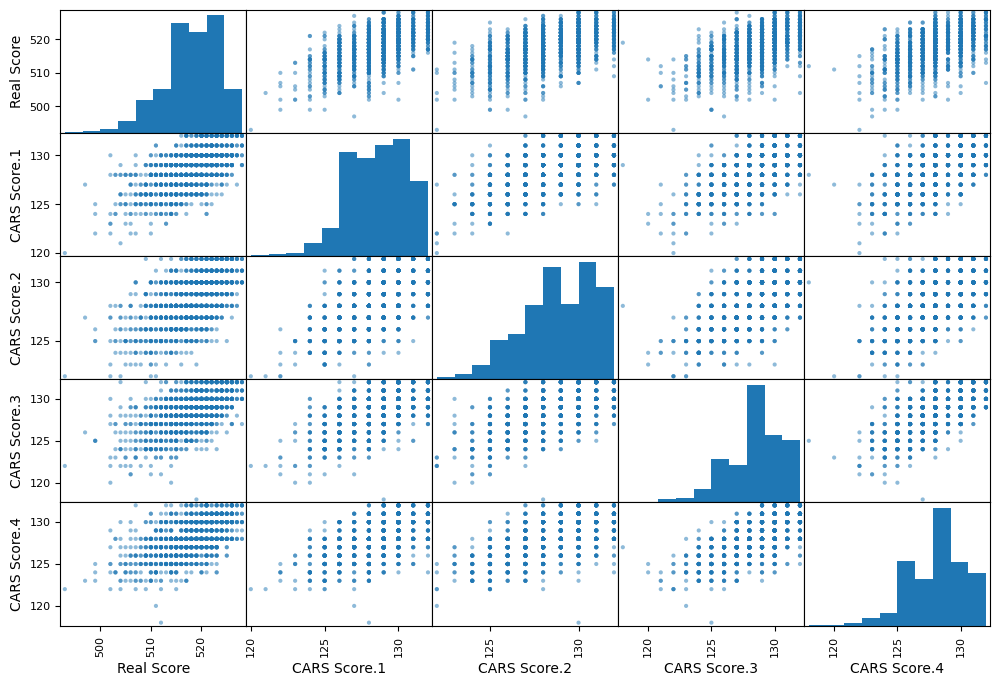

In [18]:
# create a correlation matrix with pandas
corr_matrix = scores.corr()
corr_matrix['Real Score'].sort_values(ascending=False)

# create scatter matrices displaying totals, medians.
from pandas.plotting import scatter_matrix

attributes = ['Real Score', 'CARS Score.1', 'CARS Score.2', 'CARS Score.3', 'CARS Score.4']
scatter_matrix(scores[attributes], figsize=(12, 8))

## Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

lin_reg0 = LinearRegression()
lin_reg0.fit(X_train, y_train)
y_pred = lin_reg0.predict(X_val)

# compute accuracy on the training set
accuracy = lin_reg0.score(X_val, y_val)

print("accuracy of LinReg : ", accuracy)

assert len(y_pred) == len(y_val), "the length of y_pred is incorrect"

accuracy of LinReg :  0.7623068999564993


## PCA to Create Linear Combinations of Features

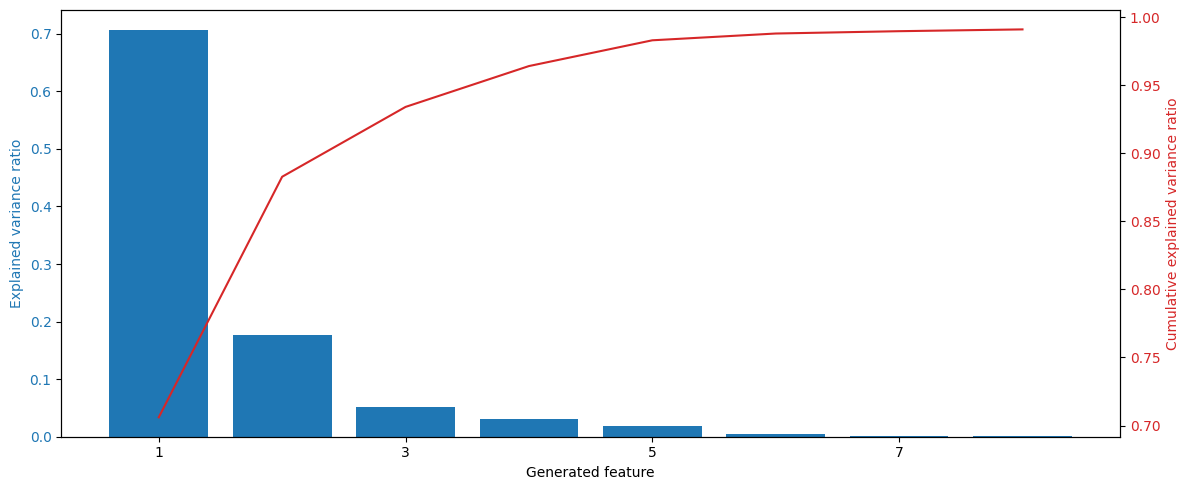

In [20]:
from sklearn.decomposition import PCA

# This code is from Assignment 2

# fit the PCA
N = 8
pca = PCA(n_components=N)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.fit_transform(X_val)

# plot the explained variances
fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=2))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()

# Select and Train a Model

## Training and Evaluating on the Training Set

In [21]:
# initialize a linear regression object
lin_reg = LinearRegression() #solver = ?
lin_reg.fit(X_train_reduced, y_train)

lin_accuracy = lin_reg.score(X_val_reduced, y_val)

# sanity check: test out predictions and compare to labels
#print(lin_reg.predict(X_train_reduced))
#print(list(y_train))

print(f"Prediction accuracy: {100*lin_accuracy:.2f}%")

Prediction accuracy: 73.52%


In [22]:
# loss function
from sklearn.metrics import mean_squared_error

y_pred = lin_reg.predict(X_val_reduced)

assert len(y_pred) == len(y_val), "the length of y_pred is incorrect"

lin_rmse = mean_squared_error(y_val, y_pred, squared=False)
lin_rmse

3.083513520615845

## Further Evaluation with Cross-Validation

In [23]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, ###, ###,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

def display_scores(scores):
    print("Scores:", lin_scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(lin_rmse_scores)

TypeError: cross_val_score() missing 1 required positional argument: 'X'

## Data visualisation

(1218, 20)


<Figure size 640x480 with 0 Axes>

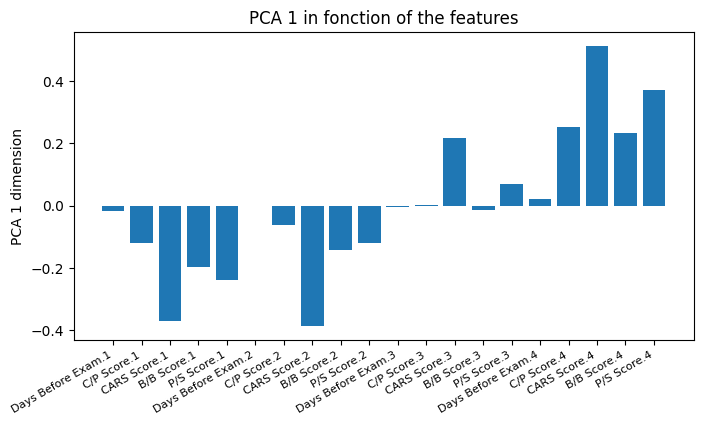

In [41]:
#Display what pca 1 is
plt.figure()

print(X.shape)
D,E = np.linalg.eig(np.matmul(X.T,X))
#print(D)
#print(D.shape)
#E = E.reshape()
z = list(scores.columns[1:])#np.arange(1,21)
#print(z)

fig, ax = plt.subplots(figsize= (8,4))
# We see that the highest eigenvalue is D[7] so row 7 of E is 
ax.bar(z, E[:,7])#, label=bar_labels, color=bar_colors)

ax.set_ylabel('PCA 1 dimension')
ax.set_title('PCA 1 in fonction of the features')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right',fontsize=8)
#ax.legend(title='Fruit color')

plt.show()

#plt.plot(z,E[0,:])

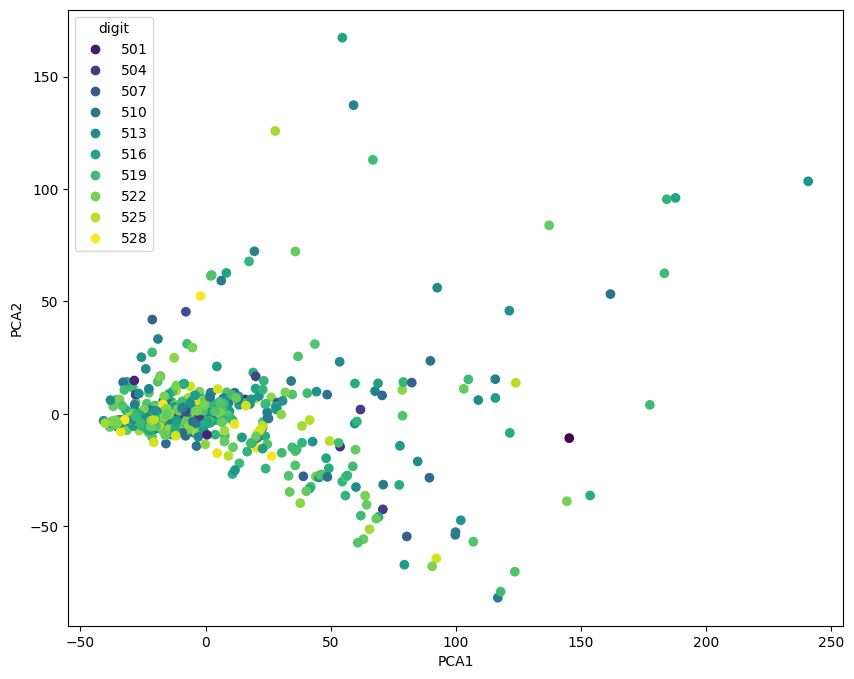

In [25]:
plt.figure(figsize=(10, 8))
# convert the labels to numbers, each will be assigned a separate color based on the cmap specified
colors = [int(x) for x in y_train]
sc = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=colors)#,s=1 cmap='tab10')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(*sc.legend_elements(), title='digit')
plt.show()


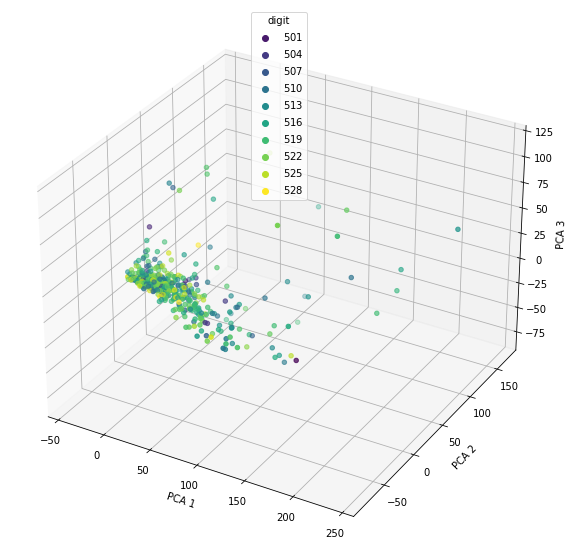

In [55]:
#3D plotting
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:,2], c=colors)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.legend(*sc.legend_elements(), title='digit',loc="upper center")
plt.show()


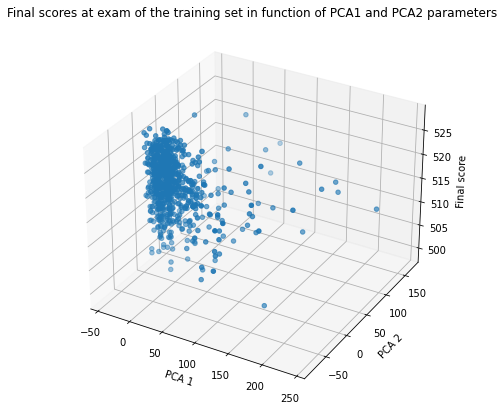

In [75]:
#3D plotting
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], y_train)#, c=colors)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel("Final score")
#plt.legend(*sc.legend_elements(), title='digit',loc="upper center")
plt.title("Final scores at exam of the training set in function of PCA1 and PCA2 parameters")
plt.show()


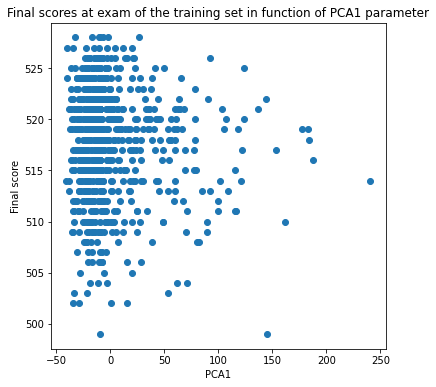

In [76]:
plt.figure(figsize=(6, 6))
# convert the labels to numbers, each will be assigned a separate color based on the cmap specified
colors = [int(x) for x in y_train]
sc = plt.scatter(X_train_reduced[:, 0],y_train)#, c=colors)#,s=1 cmap='tab10')
plt.xlabel("PCA1")
plt.ylabel("Final score")
#plt.legend(*sc.legend_elements(), title='digit')
plt.title("Final scores at exam of the training set in function of PCA1 parameter")
plt.show()
